#### Initialize Spark session

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("xor") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

sc = spark.sparkContext


#### Read in data and merge dataset on ab_id

In [2]:
pitches = spark.read.option("inferSchema", "true").csv('Data/pitches.csv', header = True)
atbats = spark.read.option("inferSchema", "true").csv('Data/atbats.csv', header = True).select("ab_id", "batter_id", 
                                                                                               "inning", "p_score", 
                                                                                               "p_throws", "pitcher_id",
                                                                                               "stand", "top")

df = pitches.join(atbats, "ab_id")

#### Drop unnecessary variables

In [3]:
df = df.drop("ax", "ay", "az", "batter_id", "break_angle", "break_length", "break_y", "code", "event", "g_id", "o",
            
             "p_throws", 'nasty',"pfx_x", "pfx_z", "px", "pz", "spin_dir", "end_speed", "start_speed"
             
             "sz_bot", "sz_top", "vx0", "vy0", "vz0", "x", "x0", "y", "y0", "z", "z0", "zone", "spin_rate")

#### Create new variable score_difference

In [4]:
df=df.withColumn("score_difference", df.p_score-df.b_score)

#### Remove low frequency observations (look at pitch_type to decide which ones to remove)

In [5]:
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import udf
from pyspark.sql import functions as f
from pyspark.sql.functions import col

In [6]:
df = df.filter(
    (col('pitch_type') != 'UN') &
    (col('pitch_type') != 'EP') &
    (col('pitch_type') != 'AB') &
    (col('pitch_type') != 'FA') &
    (col('pitch_type') != 'IN') &
    (col('pitch_type') != 'SC'))

#### FO and PO are the same so consolidate

In [7]:
df=df.na.replace(['FO'], ['PO'], 'pitch_type')

#### Create new column that is a latent variable based on pitch_type

In [8]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import CrossValidator

indexer = StringIndexer(inputCol="pitch_type", outputCol="latent_pitch_type")
df = indexer.fit(df).transform(df)
df.head(2)

[Row(ab_id=2015000044, b_count=0, b_score=0, on_1b=False, on_2b=True, on_3b=False, outs=1, pitch_num=1, pitch_type='FC', s_count=0, start_speed=84.6, sz_bot=1.52, type='B', type_confidence=2.0, inning=5, p_score=3, pitcher_id=425794, stand='L', top=False, score_difference=3, latent_pitch_type=6.0),
 Row(ab_id=2015000044, b_count=1, b_score=0, on_1b=False, on_2b=True, on_3b=False, outs=1, pitch_num=2, pitch_type='FC', s_count=0, start_speed=88.4, sz_bot=1.52, type='B', type_confidence=2.0, inning=5, p_score=3, pitcher_id=425794, stand='L', top=False, score_difference=3, latent_pitch_type=6.0)]

In [9]:
df.groupBy("latent_pitch_type").count().show()
df.groupBy("pitch_type").count().show()

+-----------------+-------+
|latent_pitch_type|  count|
+-----------------+-------+
|              8.0|  43705|
|              0.0|1014880|
|              7.0|  66484|
|              1.0| 450581|
|              4.0| 242506|
|              3.0| 292789|
|              2.0| 337983|
|             10.0|   1438|
|              6.0| 149756|
|              5.0| 234391|
|              9.0|  11260|
+-----------------+-------+

+----------+-------+
|pitch_type|  count|
+----------+-------+
|        FT| 337983|
|        SL| 450581|
|        FC| 149756|
|        FF|1014880|
|        FS|  43705|
|        PO|   1438|
|        KC|  66484|
|        CH| 292789|
|        CU| 234391|
|        KN|  11260|
|        SI| 242506|
+----------+-------+



In [10]:
## udf_latent_base = udf(lambda z: if)

#### Create new column that is latent variable based on balls and strikes

In [11]:
def count_status(b_count, s_count):
    if   b_count==0 and s_count==0: return 0
    elif b_count==1 and s_count==0: return 1
    elif b_count==0 and s_count==1: return 2
    elif b_count==1 and s_count==1: return 3
    elif b_count==2 and s_count==0: return 4
    elif b_count==0 and s_count==2: return 5
    elif b_count==3 and s_count==0: return 6
    elif b_count==2 and s_count==1: return 7
    elif b_count==1 and s_count==2: return 8
    elif b_count==3 and s_count==1: return 9
    elif b_count==2 and s_count==2: return 10
    elif b_count==3 and s_count==2: return 11
    
udfcount_status = udf(count_status, IntegerType())
df = df.withColumn("count_status", udfcount_status("b_count", "s_count"))

#### Create new column that is latent variable based on on_1b, on_2b, and on_3b

In [12]:
def base_status(on_1b, on_2b, on_3b):
    if   on_1b==0 and on_2b==0 and on_3b==0: return 0
    elif on_1b==1 and on_2b==0 and on_3b==0: return 1
    elif on_1b==0 and on_2b==1 and on_3b==0: return 2
    elif on_1b==0 and on_2b==0 and on_3b==1: return 3
    elif on_1b==1 and on_2b==1 and on_3b==0: return 4
    elif on_1b==1 and on_2b==0 and on_3b==1: return 5
    elif on_1b==0 and on_2b==1 and on_3b==1: return 6
    elif on_1b==1 and on_2b==1 and on_3b==1: return 7
    
udfbase_status = udf(base_status, IntegerType())
df = df.withColumn("base_status", udfbase_status("on_1b", "on_2b", "on_3b"))

#### Create new column binning score_difference

In [13]:
def bin_score(score_difference):
    if score_difference<(-4): return (-5)
    elif score_difference>(4): return (5)
    elif score_difference==(-3): return (-3) 
    elif score_difference==(-2): return (-2)
    elif score_difference==(-1): return (-1) 
    elif score_difference==(0): return (0) 
    elif score_difference==(1): return (1)
    elif score_difference==(2): return (2)
    elif score_difference==(3): return (3) 
udfbin_score = udf(bin_score, IntegerType())
df = df.withColumn("binned_score_difference", udfbin_score("score_difference"))

#### Create new column binning pitch_num

In [14]:
def bin_pitch_num(pitch_num):
    if pitch_num>(14): 
        return (14)
    else: 
        return(pitch_num)
udfpitch_num = udf(bin_pitch_num, IntegerType())
df = df.withColumn("pitch_num", udfpitch_num("pitch_num"))

In [15]:
df.groupby("pitch_num").count().show()

+---------+------+
|pitch_num| count|
+---------+------+
|       12|   409|
|        1|735198|
|       13|   150|
|        6|145005|
|        3|539590|
|        5|268666|
|        9|  8831|
|        4|406352|
|        8| 23528|
|        7| 60001|
|       10|  3210|
|       11|  1130|
|       14|    80|
|        2|653623|
+---------+------+



#### Create a pie plot of distribution of pitch_type

In [16]:
import matplotlib.pyplot as plt

pitch_type = df.groupby('pitch_type').count().toPandas()
fig1, ax1 = plt.subplots(figsize=(30,13))
plt.rcParams.update({'font.size': 18})
ax1.pie(pitch_type['count'],labels = pitch_type['pitch_type'], autopct='%1.0f%%', pctdistance=1.1, 
        labeldistance = 1.2, shadow = False, startangle = 90 )
#plt.legend()
plt.legend(labels = ['Two-seam Fastball', 'Slider', 'Cutter', 'Four-seam Fastball', 'Splitter', 'Knuckle Curve',
                    'Intentional Ball', 'Changeup', 'Curveball', 'Knuckleball', 'Sinker'])
ax1.axis('equal')
#plt.savefig('init_pie.png')
plt.show()

<Figure size 3000x1300 with 1 Axes>

#### Create a pie plot of distribution of pitch_type of Chris Sale

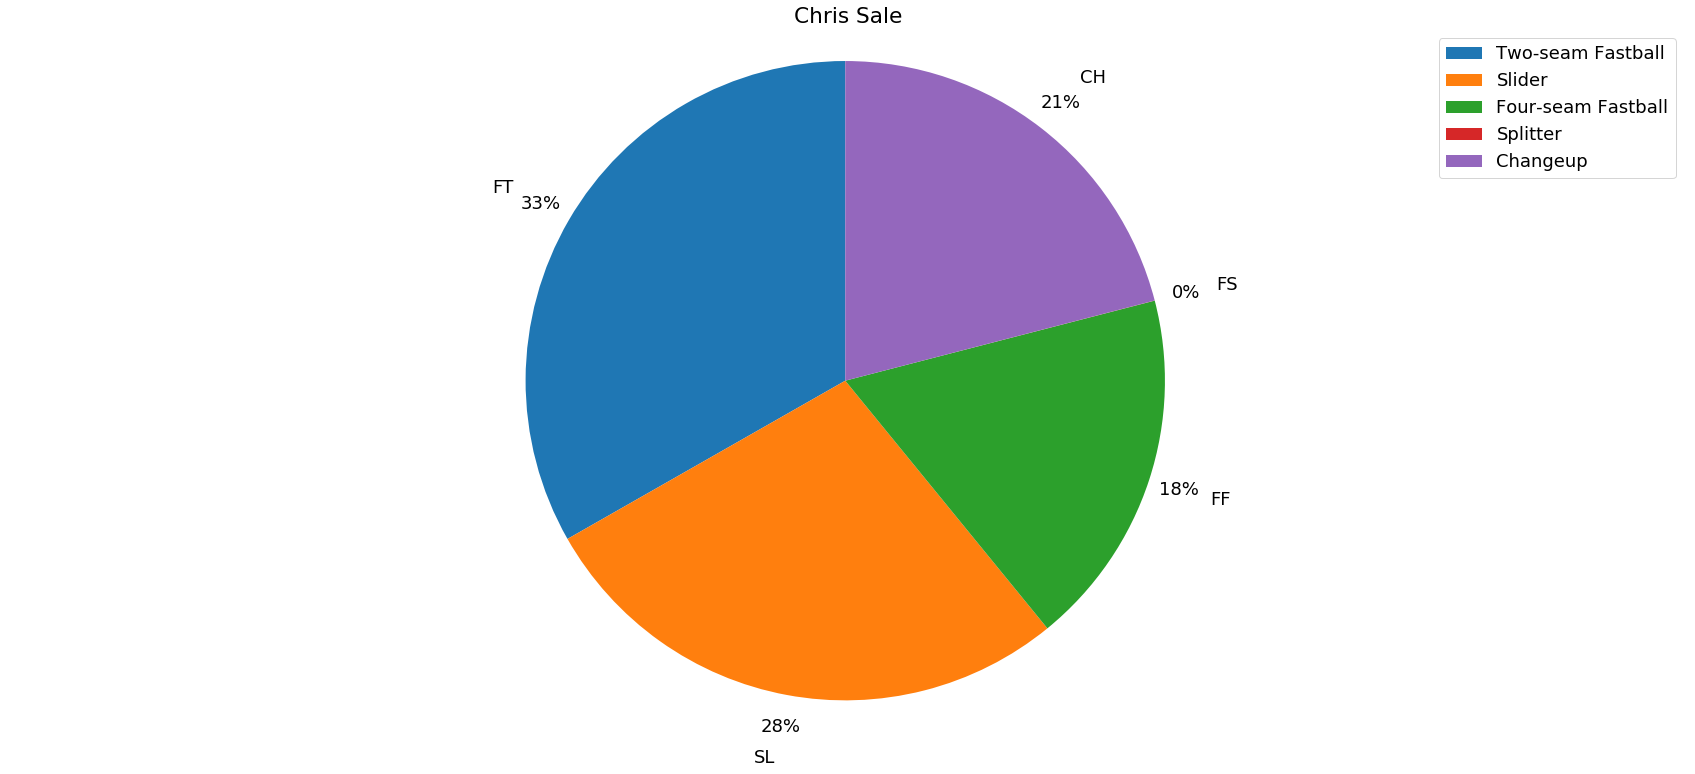

In [17]:
chris_sale = df.filter(df.pitcher_id == 519242).groupby('pitch_type').count().toPandas()
fig2, ax2 = plt.subplots(figsize=(30,13))
plt.rcParams.update({'font.size': 18})
plt.title('Chris Sale')
ax2.pie(chris_sale['count'],labels = chris_sale['pitch_type'], autopct='%1.0f%%', pctdistance=1.1, 
        labeldistance = 1.2, shadow = False, startangle = 90 )
#plt.legend()
plt.legend(labels = ['Two-seam Fastball', 'Slider', 'Four-seam Fastball', 'Splitter',
                     'Changeup'])
ax2.axis('equal')
#plt.savefig('init_pie.png')
plt.show()

In [18]:
chris_sale

,pitch_type,count
0,FT,4218
1,SL,3509
2,FF,2301
3,FS,1
4,CH,2660


#### Create a pie plot of distribution of pitch_type of Clayton Kershaw

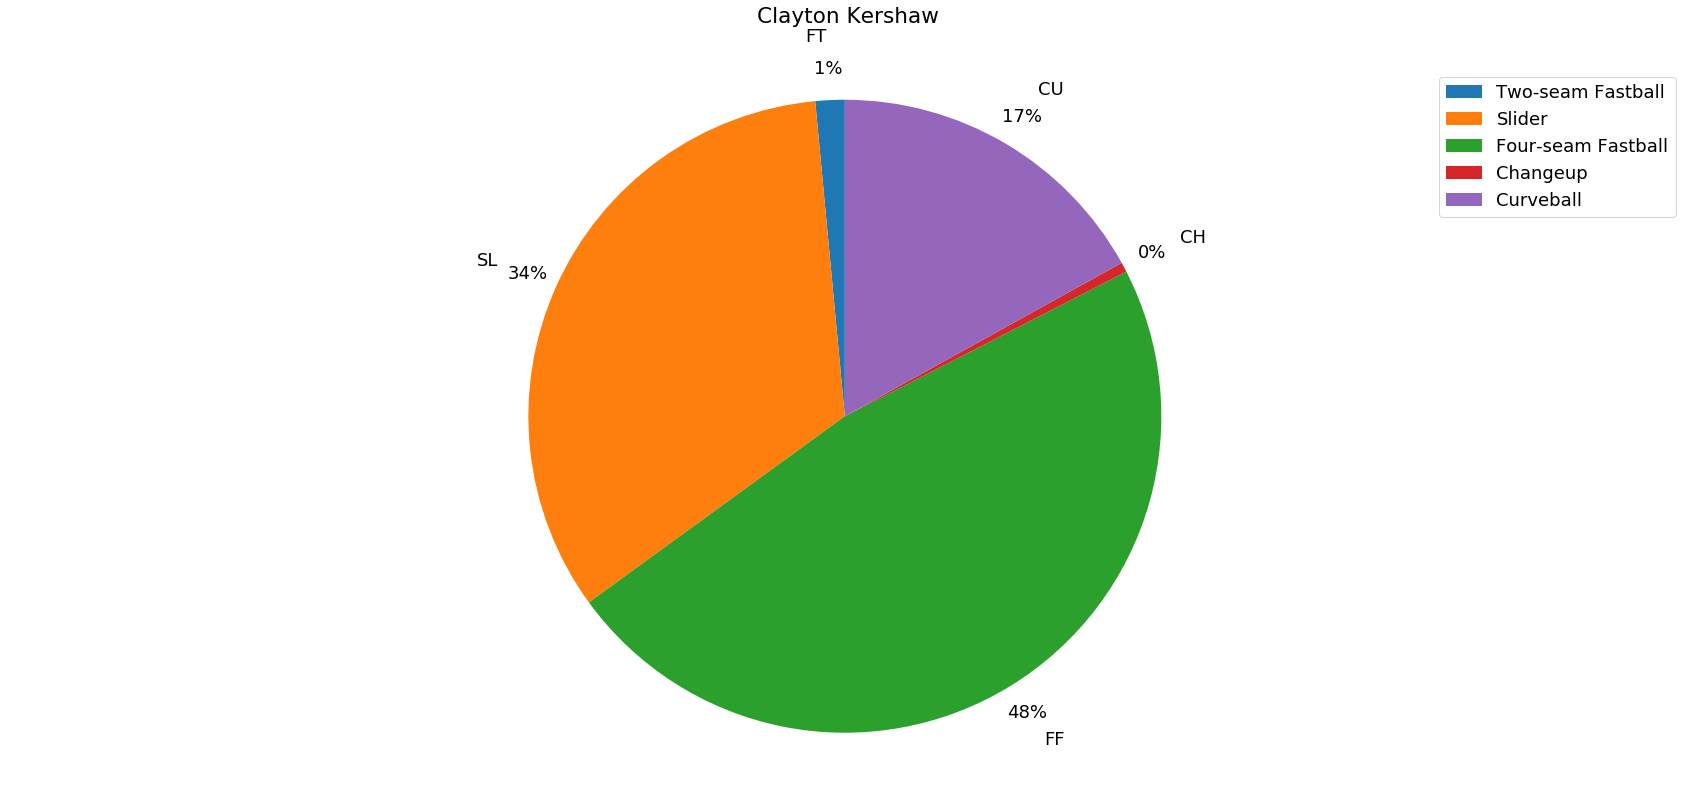

In [19]:
clay_kersh = df.filter(df.pitcher_id == 477132).groupby('pitch_type').count().toPandas()
fig3, ax3 = plt.subplots(figsize=(30,13))
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'axes.titlepad': 45})
plt.title('Clayton Kershaw',)
ax3.pie(clay_kersh['count'],labels = clay_kersh['pitch_type'], autopct='%1.0f%%', pctdistance=1.1, 
        labeldistance = 1.2, shadow = False, startangle = 90 )
#plt.legend()
plt.legend(labels = ['Two-seam Fastball', 'Slider', 'Four-seam Fastball',
                     'Changeup', 'Curveball'])
ax3.axis('equal')
#plt.savefig('init_pie.png')
plt.show()

In [20]:
clay_kersh

,pitch_type,count
0,FT,153
1,SL,3435
2,FF,4873
3,CH,51
4,CU,1737


#### Create new column of vectors of features

In [21]:
pred = ['b_count','b_score','on_1b','on_2b','on_3b',
        'outs','pitch_num','s_count','start_speed','sz_bot',
        'type_confidence','inning','p_score','pitcher_id','top',
        'score_difference','count_status','base_status','binned_score_difference']

In [22]:
df.schema

StructType(List(StructField(ab_id,IntegerType,true),StructField(b_count,IntegerType,true),StructField(b_score,IntegerType,true),StructField(on_1b,BooleanType,true),StructField(on_2b,BooleanType,true),StructField(on_3b,BooleanType,true),StructField(outs,IntegerType,true),StructField(pitch_num,IntegerType,true),StructField(pitch_type,StringType,true),StructField(s_count,IntegerType,true),StructField(start_speed,DoubleType,true),StructField(sz_bot,DoubleType,true),StructField(type,StringType,true),StructField(type_confidence,DoubleType,true),StructField(inning,IntegerType,true),StructField(p_score,IntegerType,true),StructField(pitcher_id,IntegerType,true),StructField(stand,StringType,true),StructField(top,BooleanType,true),StructField(score_difference,IntegerType,true),StructField(latent_pitch_type,DoubleType,false),StructField(count_status,IntegerType,true),StructField(base_status,IntegerType,true),StructField(binned_score_difference,IntegerType,true)))

In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

assembler = VectorAssembler(
                            inputCols=[c for c in df.columns if c in pred],
                            outputCol='features').setHandleInvalid('skip')
output = assembler.transform(df)

#### Create PCA model

In [24]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(output)

In [25]:
result = model.transform(output).select("pcaFeatures")
result.show(truncate=False)

+-------------------------------------------------------------+
|pcaFeatures                                                  |
+-------------------------------------------------------------+
|[-425794.00076797657,-80.91509963153649,-0.25557145908238454]|
|[-425794.0008041127,-84.75938382796643,9.026911067639976E-4] |
|[-425794.00076785055,-80.89323102193204,-0.2876375584286974] |
|[-425794.00078557135,-82.77460937819691,-0.17319905631052745]|
|[-425794.0008063148,-84.96521548028215,-0.04821793028883081] |
|[-425794.0008070978,-85.03531589075594,-0.06274503111427832] |
|[-593372.0008384493,-87.81400763557198,-0.2362750451418245]  |
|[-593372.0008495282,-88.97965748140042,-0.17526598440387264] |
|[-593372.0008323129,-87.14700369462894,-0.31020648958870156] |
|[-593372.0007713089,-80.62126507932335,-0.756310812123473]   |
|[-593372.0007667806,-80.12279529462896,-0.8167366281210278]  |
|[-593372.000763605,-79.78407255606837,-0.8486732766284946]   |
|[-527054.00081741,-85.19219939960094,2.

In [26]:
import pandas as pd
def pca_col(n, df):
    df = df.toPandas()
    pca_n = []
    for i in range(n):
        pca_n.append('pca %s'%i)
    for i in range(len(df.pcaFeatures)):
        df.pcaFeatures[i] = df.pcaFeatures[i].tolist()
    df = pd.DataFrame(df.pcaFeatures.values.tolist(), columns= pca_n )
    return df

In [27]:
#pca_col(3, result)

KeyboardInterrupt: 